<a href="https://colab.research.google.com/github/triishita/AIOT_PROJECT/blob/main/Copy_of_EyesDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
train_data_directory = r'/content/drive/MyDrive/PrepareData/train'
test_data_directory =  r'/content/drive/MyDrive/PrepareData/test'
validation_data_directory = r'/content/drive/MyDrive/PrepareData/train'

target_size = (80, 80)
batchsize = 8
cm = 'categorical'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_generator = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest' ,
    validation_split=0.2)


train_data = train_data_generator.flow_from_directory(train_data_directory,
                                              target_size= target_size,
                                              batch_size=batchsize,
                                              class_mode= cm,
                                              shuffle= True,
                                              subset = 'training')

validation_data = train_data_generator.flow_from_directory(validation_data_directory,
                                              target_size=target_size,
                                              shuffle= True,
                                              batch_size=batchsize,
                                              class_mode=cm,
                                              subset='validation')

Found 128 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


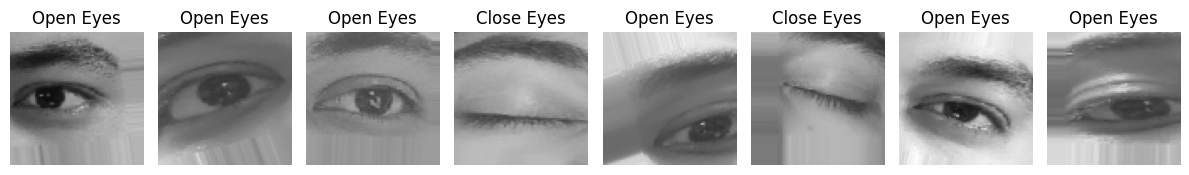

In [ ]:
import matplotlib.pyplot as plt

class_labels = {0: 'Close Eyes', 1: 'Open Eyes'}

images, one_hot_labels = next(train_data)
labels = [class_labels[idx] for idx in one_hot_labels.argmax(axis=1)]

num_images = min(batchsize, 10)
plt.figure(figsize=(12, 5))

for i in range(num_images):
    plt.subplot(2, 8, i+1)
    plt.imshow(images[i])
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
test_data_generator = ImageDataGenerator(rescale= 1./255)
test_data = test_data_generator.flow_from_directory(test_data_directory,
                                              target_size=target_size,
                                              batch_size=batchsize,
                                              class_mode= cm
                                              )

Found 40 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input , Flatten , Dense , MaxPooling2D
from tensorflow.keras.optimizers import Adam

#InceptionV3 pretrained model, just using its learning not its 1000 classes
base_model = InceptionV3(include_top=False,
                         weights='imagenet',
                         input_tensor=Input(shape=(80, 80, 3)))

base_output = base_model.output
#base_output.summary()
flattened_output = Flatten()(base_output)

#fully connected layer with 64 neurons
dense_layer = Dense(64, activation='relu')(flattened_output)

#dropout layer to reduce overfitting
dropout_layer = Dropout(0.5)(dense_layer)

#final output layer with 2 neurons beacuse we have 2 classes
output_layer = Dense(2, activation='softmax')(dropout_layer)

#custom model specifying the input and output layers
custom_model = Model(inputs=base_model.input, outputs=output_layer)

# Freezeweights of base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
custom_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 80, 3)]          0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 39, 39, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 39, 39, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 39, 39, 32)           0         ['batch_normalization_94

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
#Path to save your model
model_path = r'eye.h5'

In [ ]:
#Callbacks and conditions for stopping the epochs and specific runs and storing the best values in the model

val_accuracy_monitor = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, patience=5, verbose = 3)

accuracy_monitor = ModelCheckpoint(model_path, monitor='accuracy', save_best_only=True , patience = 5 ,verbose=3)

val_loss_monitor = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True , patience = 5 , verbose=3)

earlystopping_condition = EarlyStopping(monitor= 'val_loss' , patience=5 , restore_best_weights=True , verbose = 3)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience = 5 , verboes = 3)


training_monitors = [val_accuracy_monitor, accuracy_monitor , val_loss_monitor, earlystopping_condition, learning_rate]

In [ ]:
train_steps_per_epoch = len(train_data)
val_steps_per_epoch = len(validation_data)

print(train_steps_per_epoch)
print(val_steps_per_epoch)

16
4


In [ ]:
epochs = 25

In [ ]:
custom_model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])

In [ ]:
hist = custom_model.fit(train_data,
                           steps_per_epoch=train_steps_per_epoch,
                           epochs=epochs,
                           validation_data=validation_data,
                           validation_steps=val_steps_per_epoch,
                           callbacks=training_monitors)

Epoch 1/25
16/16 [==============================] - ETA: 0s - loss: 0.4549 - accuracy: 0.7578
Epoch 1: val_accuracy improved from -inf to 0.93750, saving model to eye.h5

Epoch 1: accuracy improved from -inf to 0.75781, saving model to eye.h5

Epoch 1: val_loss improved from inf to 0.19393, saving model to eye.h5
16/16 [==============================] - 23s 539ms/step - loss: 0.4549 - accuracy: 0.7578 - val_loss: 0.1939 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 2/25
16/16 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9219
Epoch 2: val_accuracy did not improve from 0.93750

Epoch 2: accuracy improved from 0.75781 to 0.92188, saving model to eye.h5

Epoch 2: val_loss improved from 0.19393 to 0.11734, saving model to eye.h5
16/16 [==============================] - 4s 232ms/step - loss: 0.2155 - accuracy: 0.9219 - val_loss: 0.1173 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/25
16/16 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9375
Epoch

In [ ]:
# Extract final training and validation accuracy
final_training_accuracy = hist.history['accuracy'][-1]
final_validation_accuracy = hist.history['val_accuracy'][-1]

print("Final Training Accuracy:", final_training_accuracy)
print("Final Validation Accuracy:", final_validation_accuracy)


Final Training Accuracy: 0.9921875
Final Validation Accuracy: 0.96875


In [ ]:
training_loss = hist.history['loss']
training_accuracy = hist.history['accuracy']

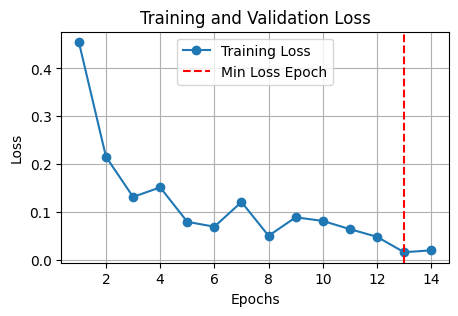

In [ ]:
import matplotlib.pyplot as plt

num_epochs_completed = len(training_loss)
min_val_loss_epoch = training_loss.index(min(training_loss)) + 1

plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs_completed + 1), training_loss, label='Training Loss', marker='o')
plt.axvline(x=min_val_loss_epoch, color='r', linestyle='--', label='Min Loss Epoch')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

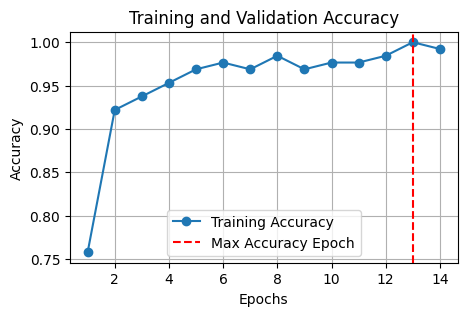

In [ ]:
max_val_accuracy_epoch = training_accuracy.index(max(training_accuracy)) + 1

plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs_completed + 1), training_accuracy, label='Training Accuracy', marker='o')
plt.axvline(x=max_val_accuracy_epoch, color='r', linestyle='--', label='Max Accuracy Epoch')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

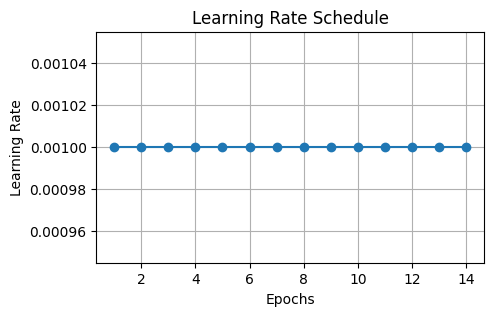

In [ ]:
learning_rates = hist.history['lr']

plt.figure(figsize=(5, 3))
plt.plot(range(1, len(learning_rates) + 1), learning_rates, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)
plt.show()

In [ ]:
import cv2
import os
from tensorflow.keras.models import load_model
from pygame import mixer
import time
import numpy as np

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_eye.xml")
#model = load_model(os.path.join("modelss", "eye.h5"))
model = load_model('eye.h5',compile=False)

In [ ]:
def preprocess_eye(eye):
    eye = cv2.resize(eye, (80, 80))
    eye = eye / 255.0
    eye = np.expand_dims(eye, axis=0)
    return eye

In [ ]:

img = r'/content/drive/MyDrive/test_image_t.jpg'  #new unseen image path to predict
frame = cv2.imread(img)

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, minNeighbors=15, scaleFactor=1.2, minSize=(25, 25))
eyes = eye_cascade.detectMultiScale(gray, minNeighbors=12, scaleFactor=1.2)

for (x, y, w, h) in eyes:
    eye = frame[y:y + h, x:x + w]
    eye = preprocess_eye(eye)
    prediction = model.predict(eye, verbose = 0 )

    probability_close = prediction[0][0]
    probability_open = prediction[0][1]

    probability_close_percent = probability_close * 100
    probability_open_percent = probability_open * 100

    if prediction[0][1] > prediction[0][0]:
        eye_status = "Open"
    else:
        eye_status = "Close"


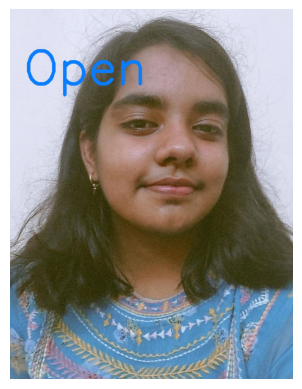

[[0.00112171 0.9988783 ]]
Open
Probability of Close: 0.11%
Probability of Open: 99.89%


In [ ]:
cv2.putText(frame, eye_status, (35,190) , cv2.FONT_HERSHEY_SIMPLEX, 4, (253,125,10), 8)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

print(prediction)
print(eye_status)
print(f"Probability of Close: {probability_close_percent:.2f}%")
print(f"Probability of Open: {probability_open_percent:.2f}%")


In [ ]:
%pip install -q "openvino>=2023.1.0" #installing openvino

In [ ]:
import openvino as ov
core = ov.Core()
core

<Core: available plugins[CPU]>

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('eye.h5',compile=False)

In [ ]:
# If you want to save and load on any machine, use this code
# we are using this 'convert' model so that at the end we have the required 'openvino' model,
# because 'openvino' is a model that runs on all devices irrespective of the apps and packages installed on those devices.
# we convert the model made above to the OpenVino model
ir_model = ov.convert_model(model, input=[1, 80, 80, 3])  # [1,64,64,3] means 4 dimensions are here, hav echanged it accordingly from the given 'input_shape' from above the code.
ov.save_model(ir_model, "blink_CNN.xml")
